# Notebook for RDE activity analysis

See analysis_RDE.py for more information about the functions.

### 1. Initialization.

In [1]:
%load_ext autoreload
from analysis_RDE import *
from analysis_RDE import ECSA_calculation
import tkinter as tk
from tkinter import filedialog 
from tkinter import messagebox
import os
import pandas as pd
from numpy import savetxt

root = tk.Tk()
root.withdraw()
root.lift()
root.attributes("-topmost", True)

''

### 1.1 Introducting experimental parameters.

In [2]:
reference = 0               # V
A_geo = 0.196               # cm2
loading = 10                # ug/cm2
ir_comp = 26                # ohm
charge_ecsa = 0.000210      # C/cm2
Pt_mass = loading * A_geo   # ug
scan_rate = 0.05            # V/s for CO stripping
F = 96485                   # C/mol, Faraday constant
D02 = 0.000019              # cm2/s, diffusion constant O2
C_R = 0.0000012             # mol/cm3, analyte concentration
nu = 0.01                   # cm2/s, viscosity

index = 9                   # number of lines of info to be removed

### 2. Choose which file(s) to analyze.

#### 2A. Analysis of one file: Open the file with the interesting voltage and current data.

In [3]:
%autoreload
nbr_files = 1
file = filedialog.askopenfilename(title="Choose the file to be analyzed.")
V, I = get_voltage_current(file, index)
print(file)

L:/P15 SEM/Linnéa/2024_03_2627/Activity/ML00_M029_Cyc0001.txt


-0.002078
-0.001657


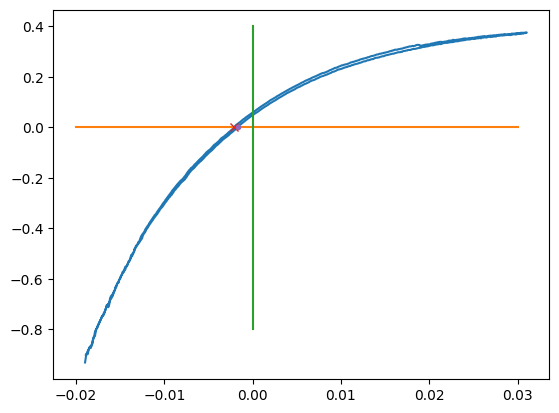

In [4]:
zero_current_x = np.linspace(-0.02,0.03,len(V))
zero_current_y = np.linspace(0,0,len(I))
plt.plot(V,I)
plt.plot(zero_current_x,zero_current_y)
plt.plot(np.linspace(0,0,100), np.linspace(-0.8,0.4,100))
switching_index = V.index(np.max(V))
intersection_indices = np.argwhere(np.diff(np.sign(I - zero_current_y))).flatten()
for e in intersection_indices:
    if e < switching_index:
        hydroflex_pot_forward = V[e]
    else:
        hydroflex_pot_backward = V[e]
# hydroflex_pot_forward = V[intersection_indices[0]]
# hydroflex_pot_backward = V[intersection_indices[1]]
print(hydroflex_pot_forward)
print(hydroflex_pot_backward)
plt.plot(V[intersection_indices[0]],I[intersection_indices[0]],'x')
plt.plot(V[intersection_indices[1]],I[intersection_indices[1]],'.')

#### 2B. Analysis of several files: Open the files with the interestig voltage and current data.

In [8]:
%autoreload
nbr_files = 2 #not important, just not 1
files = filedialog.askopenfilenames(title="Choose the files to be analyzed.")
print(files)
data_matrix = []

for file in files: 
    V_i, I_i = get_voltage_current(file, index)
    data_matrix.append(V_i)
    data_matrix.append(I_i)

data_matrix = np.transpose(data_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

('L:/P15 SEM/Linnéa/2024_03_1920/Activity/ML02_M017_Cyc0015.txt', 'L:/P15 SEM/Linnéa/2024_03_1920/Activity/ML02_M018_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_03_1920/Activity/ML02_M019_Cyc0003.txt', 'L:/P15 SEM/Linnéa/2024_03_1920/Activity/ML02_M020_Cyc0003.txt')


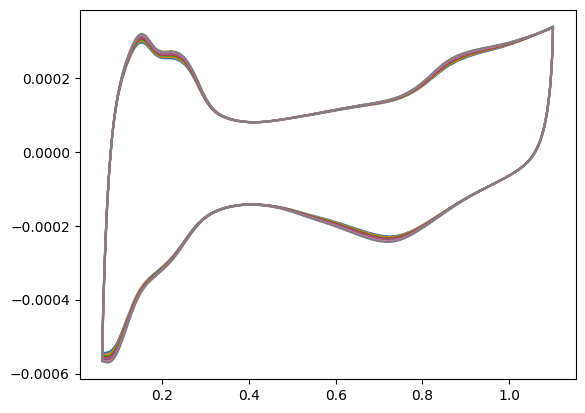

In [20]:
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'previous']
for i in range(4,len(data_matrix[0]),2):
    plt.plot(data_matrix[:,i], data_matrix[:,i+1])
#plt.plot(V,I)
#plt.legend(labels)

##### 2B.1 Optional: Rearrange the data so it's stored with the lowest rotation rate first.

In [9]:
V_400 = data_matrix[:,6]
I_400 = data_matrix[:,7]
data_matrix = np.insert(data_matrix, 0, V_400, axis=1)
data_matrix = np.insert(data_matrix, 1, I_400, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)
data_matrix = np.delete(data_matrix, 8, axis=1)

### 3. Introduce background: choose the corresponding file(s).

In [4]:
%autoreload
if nbr_files == 1:
    background_file = filedialog.askopenfilename(title="Choose the background file.")
    print(background_file)
    background_V, background_I = get_background(background_file, index)
else:
    background_files = filedialog.askopenfilenames(title="Choose the background files.")
    print(background_files)
    background_matrix = []
    for i, background_file in enumerate(background_files): 
        V_i, I_i = get_background(background_file, index)
        background_matrix.append(V_i)
        background_matrix.append(I_i)

    background_matrix = np.transpose(background_matrix)  #matrix with columns as follows: [V(file1); I(file1); V(file2); I(file2); ...]

L:/P15 SEM/Linnéa/2024_03_2627/Activity/ML00_M029_Cyc0002.txt


### 4. Corrections.
The following corrections can be made:
* Adjusting voltage to RHE potential.
* Background adjustment of current.
* iR-drop correction (usually done directly by Labview).

In [7]:
%autoreload
if nbr_files == 1:
    background_V_RHE = copy.deepcopy(background_V)
    background_I_RHE = copy.deepcopy(background_I)
    V_RHE = copy.deepcopy(V)
    I_corrected = copy.deepcopy(I)

    V_RHE = RHE_correction(V_RHE, reference)
    I_corrected = background_correction_current(I_corrected, background_I_RHE)   
else:
    background_RHE = copy.deepcopy(background_matrix)
    background_RHE = RHE_correction_background(background_RHE, -hydroflex_pot_forward)
    data_RHE = copy.deepcopy(data_matrix)
    corrected_data_RHE = copy.deepcopy(data_matrix)
    
    for i in range(len(data_matrix[0])):
        if i % 2 == 0:      #voltage are stored in even indexed columns
            data_RHE[:,i] = RHE_correction(data_RHE[:,i], -hydroflex_pot_forward)
            corrected_data_RHE[:,i] = RHE_correction(corrected_data_RHE[:,i], -hydroflex_pot_forward)
        else:               #current
            corrected_data_RHE[:,i] = background_correction_current(corrected_data_RHE[:,i], background_RHE[:,1])
            #last index need to be changed to i if you have one background file for each data file

### 5. Normalizing to geometric surface area and mass.

In [34]:
%autoreload
if nbr_files == 1:
    mass_I = copy.deepcopy(I_corrected)
    surface_I = copy.deepcopy(I_corrected)

    mass_I, surface_I = normalizing(mass_I, loading, A_geo)
else:
    mass_matrix = copy.deepcopy(corrected_data_RHE)
    surface_matrix = copy.deepcopy(corrected_data_RHE) 

    for i in range(1, len(data_matrix[0]), 2):  #only looping the current columns
        mass_matrix[:,i], surface_matrix[:,i] = normalizing(mass_matrix[:,i], loading, A_geo)

### 6. Plotting
Plotting polarisation curves.

Text(0.5, 1.0, 'Background corrected current density')

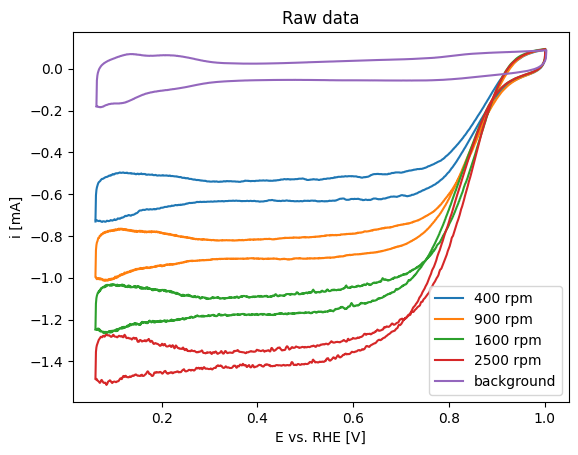

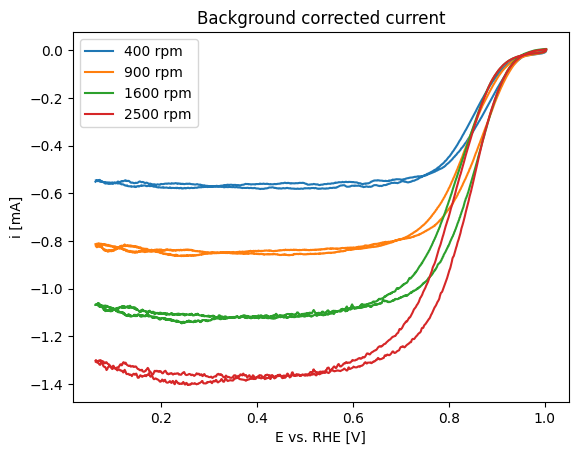

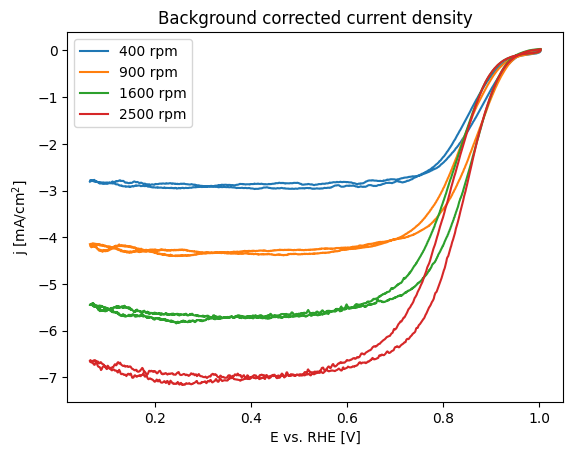

In [35]:
legend = ["400 rpm", "900 rpm", "1600 rpm", "2500 rpm", "background"]

fig1, ax1 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax1.plot(data_matrix[:,i], data_matrix[:,i+1])
ax1.plot(background_RHE[:,0], background_RHE[:,1])
ax1.legend(legend, loc='lower right')  
ax1.set_xlabel('E vs. RHE [V]')
ax1.set_ylabel('i [mA]')
ax1.set_title('Raw data')

fig2, ax2 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax2.plot(corrected_data_RHE[:,i],corrected_data_RHE[:,i+1])
ax2.legend(legend)
ax2.set_xlabel('E vs. RHE [V]')
ax2.set_ylabel('i [mA]')
ax2.set_title('Background corrected current')

fig3, ax3 = plt.subplots()
for i in range(0,len(data_matrix[0]),2):
    ax3.plot(surface_matrix[:,i],surface_matrix[:,i+1])
ax3.legend(legend)
ax3.set_xlabel('E vs. RHE [V]')
ax3.set_ylabel('j [mA/cm$^2$]')
ax3.set_title('Background corrected current density')

### 7. Analysis.

##### 7.1 ECSA & Specific activity.
Look at the CO stripping file.

ECSA CO stripping: 1.3111074017093491 cm2	Specific ECSA CO stripping: 66.89323478108923 m2/g(Pt)
ECSA HUPD: 1.340484332995525 cm2		Specific ECSA HUPD: 68.39205780589414 m2/g(Pt) 
		---------------------------------------------------------


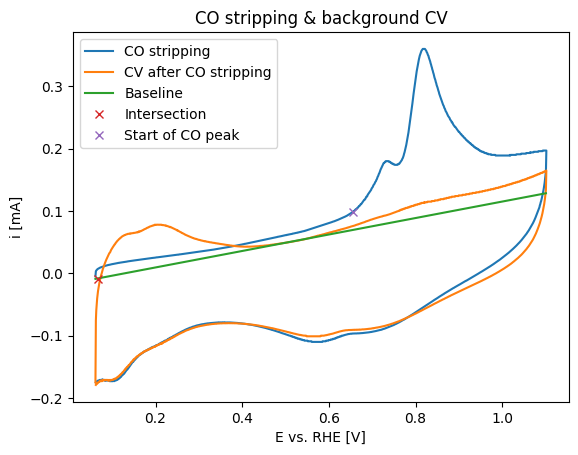

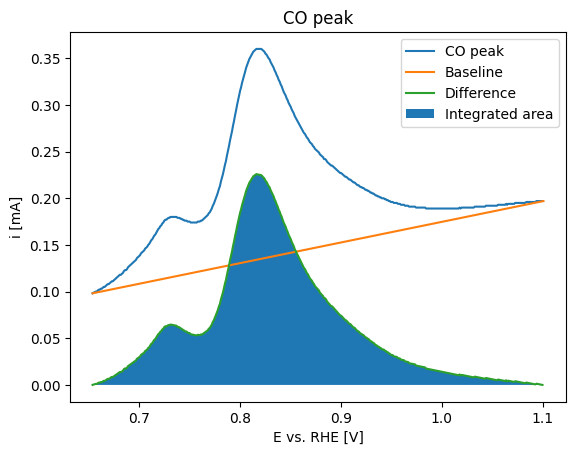

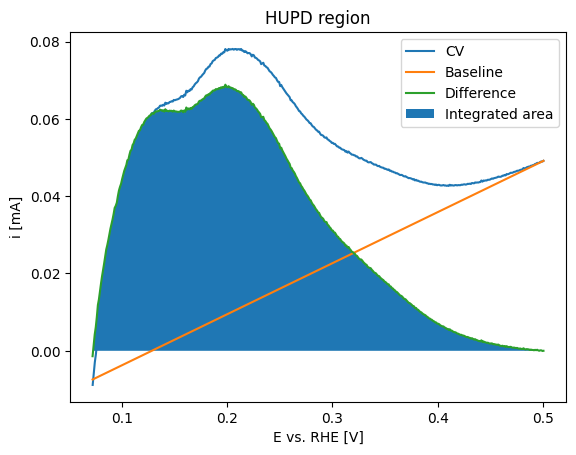

In [8]:
%autoreload
lower_voltage = 0.06
upper_voltage = 1.1
DL_start = 0.5   #NEED TO TUNE THIS
DL_end = 0.55
tolerence = 0.4

ecsa_calculation = ECSA_calculation(V_RHE, I, background_V_RHE, background_I)

ECSAs, specific_ECSAs = ecsa_calculation.calculating_ECSA(
    lower_voltage,
    upper_voltage,
    DL_start,
    DL_end,
    tolerence,
    scan_rate,
    charge_ecsa,
    Pt_mass,
)

ecsa_calculation.plotting()

##### Calculating specific and mass activities.
$SA = \frac{\frac{I*I_d}{I_d-I}}{ECSA} = \frac{I_k}{ECSA}$

$MA = \frac{I_k}{ECSA}$

In [37]:
%autoreload
diffusion_voltage = 0.40
kinetic_voltage = 0.90

SA_CO, SA_hupd, MA = obtain_activities(diffusion_voltage, kinetic_voltage, corrected_data_RHE, ECSAs, Pt_mass)

Diffusion limiting current at 0.4 and 1600 rpm V [mA]:
 1.1157580599999999

Specific activity (CO) at 0.9 V and 1600 rpm [mA/cm2]:
 0.12348776026210571

Specific activity (HUPD) at 0.9 V and 1600 rpm [mA/cm2]:
 0.1271576708216052

 Mass activity at 0.9 V and 1600 rpm [mA/ug(Pt)]:
 0.11087664036263345


##### 7.2 Koutecký-Levich analysis

KL equation: $\frac{1}{i} = \frac{1}{i_k} + \frac{1}{i_m}$

$i$: measured current  
$i_k$: kinetic current, electron transfer limitations   
$i_m$: mass transfer limited current

$\frac{1}{i} = \frac{1}{nFC_Rk_f} + \frac{1}{0.62nFAC_RD^{2/3}\nu^{-1/6}} \cdot \frac{1}{\omega^{1/2}}$

Diffusion region: y= -0.011 * x + -0.0
Kinetic region: y= 0.006 * x +  -0.012

R-value diffusion model:  0.9998217544338068 
R-value kinetic model:  0.04943328653339196


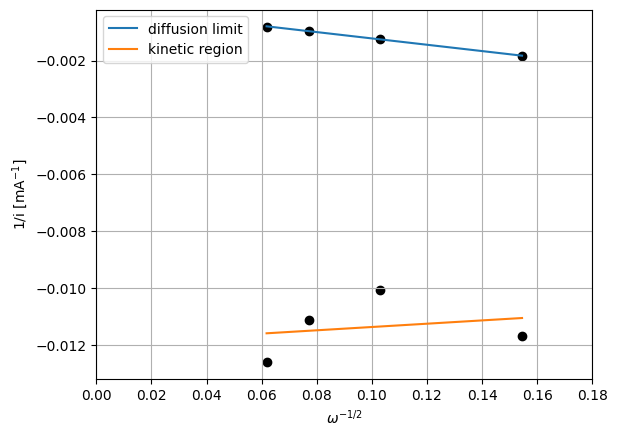

In [38]:
F = 96485
C = 1.2*pow(10,-6)
D23 = 7.12*pow(10,-4)
nu = 2.15443469

f = [400, 900, 1600, 2500]   #rpm
w = [2*np.pi*i/60 for i in f]   #to rad/s

diffusion_voltage = 0.40
kinetic_voltage = 0.90

diffusion_points = []
kinetic_points = []
for i in range(0,len(corrected_data_RHE[0]),2):  
    V_list = list(corrected_data_RHE[:,i])
    elm_i_diffusion = next(x for x in V_list if x >= diffusion_voltage)
    point_i_diffusion = corrected_data_RHE[V_list.index(elm_i_diffusion)][i+1]
    diffusion_points.append(point_i_diffusion)

    elm_i_kinetic = next(x for x in V_list if x >= kinetic_voltage)
    point_i_kinetic = corrected_data_RHE[V_list.index(elm_i_kinetic)][i+1]
    kinetic_points.append(point_i_kinetic)

x = [1/np.sqrt(i) for i in w]
y_diffusion = [1/(1000*i) for i in diffusion_points]
y_kinetic = [1/(1000*i) for i in kinetic_points]

# Linear regression
model1 = np.polyfit(x,y_diffusion,1)
print("Diffusion region: y=",round(model1[0],3),"* x +", round(model1[1],3))
predict1 = np.poly1d(model1)

model2 = np.polyfit(x,y_kinetic,1)
print("Kinetic region: y=",round(model2[0],3),"* x + ", round(model2[1],3))
predict2 = np.poly1d(model2)

#Model accuracy
from sklearn.metrics import r2_score
R2_diffusion = r2_score(y_diffusion, predict1(x))
R2_kinetic = r2_score(y_kinetic, predict2(x))
print('\nR-value diffusion model: ',R2_diffusion,'\nR-value kinetic model: ',R2_kinetic)

#Plotting
x_lin_reg = np.linspace(np.min(x), np.max(x))
plt.scatter(x, y_diffusion, c="black")
y_reg_diffusion = predict1(x_lin_reg)
plt.plot(x_lin_reg, y_reg_diffusion, label = "diffusion limit")

plt.scatter(x, y_kinetic, c="black")
y_reg_kinetic = predict2(x_lin_reg)
plt.plot(x_lin_reg, y_reg_kinetic, label = "kinetic region")

plt.xlabel("$\\omega^{-1/2}$")
plt.ylabel("1/i [mA$^{-1}$]")
plt.xlim([0, 0.18])   #this might need to be adjusted
plt.grid()
plt.legend()